# EPL Weekly goals time series analysis

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Data: EPL Data over the past 3 years
df = pd.read_csv('personal-r-projs/2022-2024EPL_data_worldfootballR.csv')

In [7]:
## Check and explore 
df.columns
df = df[['Season_End_Year', 'Wk','Day', 'Date', 'Time', 'Home', 'Away', 'HomeGoals', 'AwayGoals']]
df.describe()

,Season_End_Year,Wk,HomeGoals,AwayGoals
count,1140.000000,1140.000000,1140.000000,1140.000000
mean,2023.000000,19.500000,1.649123,1.334211
std,0.816855,10.970669,1.375073,1.244361
min,2022.000000,1.000000,0.000000,0.000000
25%,2022.000000,10.000000,1.000000,0.000000
50%,2023.000000,19.500000,1.000000,1.000000
75%,2024.000000,29.000000,2.000000,2.000000
max,2024.000000,38.000000,9.000000,8.000000


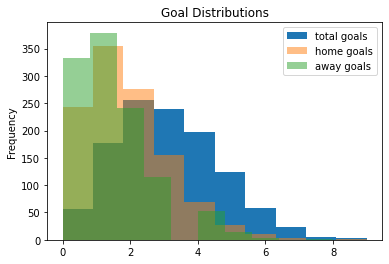

In [16]:
df['totalGoals'] = df.HomeGoals + df.AwayGoals

## Plot goals 
df.totalGoals.plot(kind = 'hist', label = 'total goals', legend = True)
df.HomeGoals.plot(kind = 'hist', label = 'home goals', legend = True, alpha = 0.5)
df.AwayGoals.plot(kind = 'hist', label = 'away goals', legend = True, alpha = 0.5)
plt.title('Goal Distributions')
plt.show()

In [ ]:
## Encoding the categorical variables -- turn team name to team id 
teams = pd.concat([df.Home, df.Away])

In [23]:
teams = pd.concat([df.Home, df.Away]).unique()
team_to_id = {team: i for i, team in enumerate(teams)}
df['HomeTeamID'] = df.Home.map(team_to_id)
df['AwayTeamID'] = df.Away.map(team_to_id)

# Exploring weekly total goals 

In [53]:
df = df.sort_values(['Season_End_Year', 'Wk'])
df['RunningWeek'] = df.groupby(['Season_End_Year', 'Wk']).ngroup()+1
df.RunningWeek


0         1
1         1
2         1
3         1
4         1
       ... 
1075    114
1076    114
1077    114
1078    114
1079    114
Name: RunningWeek, Length: 1140, dtype: int64

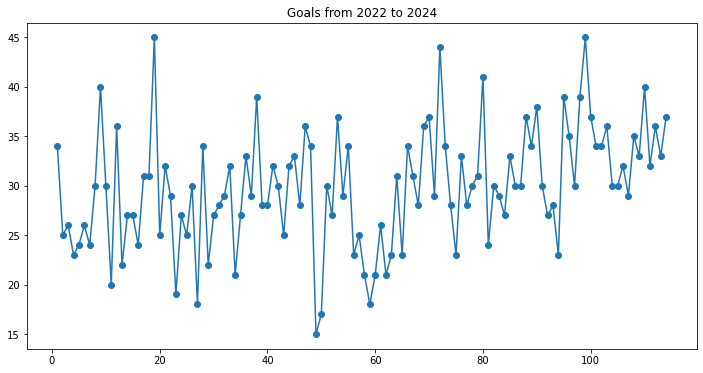

In [64]:
weeklyGoals = df.groupby('RunningWeek')['totalGoals'].sum()

## Plot 
plt.figure(figsize=(12,6))
plt.plot(weeklyGoals, marker = 'o')
plt.title(f'Goals from {df.Season_End_Year.min()} to {df.Season_End_Year.max()}')
plt.show()

## Seasonal Decomposition

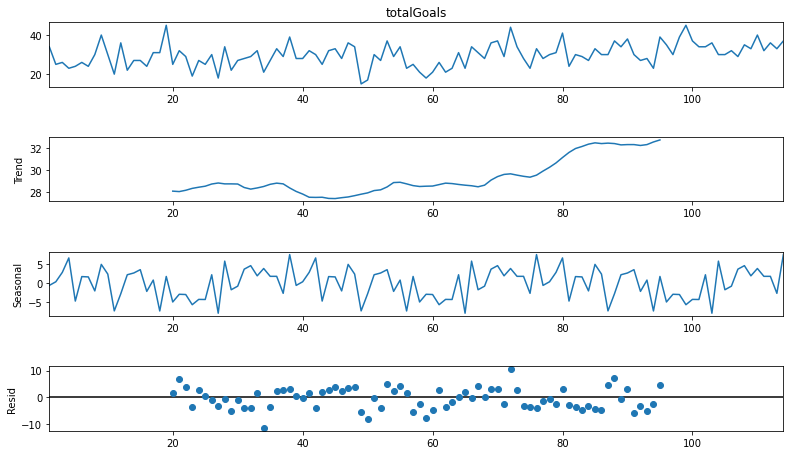

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(weeklyGoals, period = 38, ##number of games a season
                                   model = 'additive')
fig = decomposition.plot()
fig.set_size_inches(12, 7)
plt.show()

Not the best - we still see some pattern in the residuals (periods where the residuals are positive or negative together)

The visualisation does suggest some potential trend (increasing number of goals over time)

# ARIMA analysis

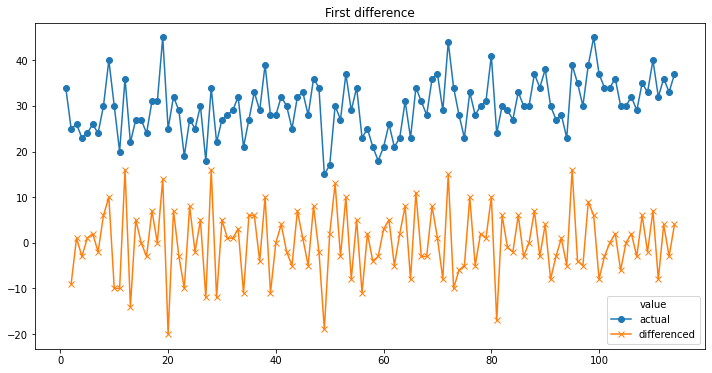

In [92]:
## First differencing 
weeklyGoals_differenced = weeklyGoals.diff()

plt.figure(figsize=(12,6))
plt.plot(weeklyGoals, marker = 'o', label = 'actual')
plt.plot(weeklyGoals_differenced, marker = 'x', label = 'differenced')
plt.legend(title = 'value')
plt.title('First difference')
plt.show()

Stationarity looks improved with differencing. We can test it quantitatively.

In [102]:
from statsmodels.tsa.stattools import adfuller

def adf_test(ts_data):
    ts_data = ts_data.dropna()
    print('Results of Dickey Fuller test')
    dftest = adfuller(ts_data, autolag = 'AIC')
    dfoutput = pd.Series(
        dftest[0:4], 
        index = ['test stat', 'p val', 'lags used', 'num observations']
    )

    for key,value in dftest[4].items():## the 4th element is a dic
        dfoutput['critical value (%s)'%key] = value
    print(dfoutput)


In [104]:
## for original data
adf_test(weeklyGoals)
print('=======================')
adf_test(weeklyGoals_differenced)

Results of Dickey Fuller test
test stat                -5.219712
p val                     0.000008
lags used                 1.000000
num observations        112.000000
critical value (1%)      -3.490131
critical value (5%)      -2.887712
critical value (10%)     -2.580730
dtype: float64
Results of Dickey Fuller test
test stat              -7.613718e+00
p val                   2.220171e-11
lags used               5.000000e+00
num observations        1.070000e+02
critical value (1%)    -3.492996e+00
critical value (5%)    -2.888955e+00
critical value (10%)   -2.581393e+00
dtype: float64


In both cases, evidence point towards stationarity, but the extent of evidence is stronger after differencing.

/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


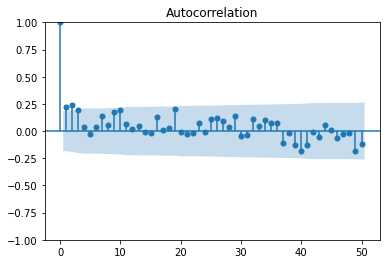

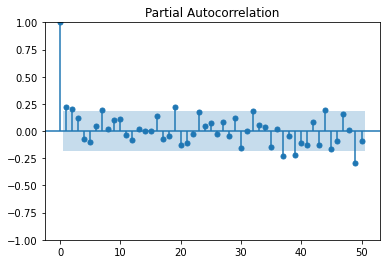

In [75]:
## Finding seasonality 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(weeklyGoals, lags = 50)
plot_pacf(weeklyGoals, lags = 50)
plt.show()

## Test out AR(2) model, based off the autocorrelation plots

In [76]:
from statsmodels.tsa.arima.model import ARIMA

In [84]:
ar2 = ARIMA(weeklyGoals, order = (2,0,0))
ar2_result = ar2.fit()
print(ar2_result.summary())


                               SARIMAX Results                                
Dep. Variable:             totalGoals   No. Observations:                  114
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -360.082
Date:                Wed, 27 Nov 2024   AIC                            728.165
Time:                        10:52:26   BIC                            739.109
Sample:                             0   HQIC                           732.607
                                - 114                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8880      0.862     34.669      0.000      28.198      31.578
ar.L1          0.1759      0.091      1.940      0.052      -0.002       0.354
ar.L2          0.2017      0.104      1.935      0.0

/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [86]:
ar2_result.forecast(steps = 3)

/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


114    31.766844
115    31.652882
116    30.577422
Name: predicted_mean, dtype: float64

## Compare between a few models

In [112]:
def fit_arima_model_results(data, order):
    model = ARIMA(data, order = order)
    results = model.fit()
    return{
        'order': order, 
        'aic': results.aic,
        'bic': results.bic
    }

## Orders to test 
orders= [(1,1,1), (2,1,1), (1,0,1), (1,0,0), (0,0,1)]


In [113]:
results_list = []
for order in orders:
    results = fit_arima_model_results(weeklyGoals, order = order)
    results_list.append(results)

results_df = pd.DataFrame(results_list)
print(results_df)

/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored 

       order         aic         bic
0  (1, 1, 1)  722.496975  730.679138
1  (2, 1, 1)  722.771588  733.681139
2  (1, 0, 1)  728.241832  739.186625
3  (1, 0, 0)  730.857276  739.065871
4  (0, 0, 1)  732.464541  740.673136


In [116]:
results_df.sort_values(['aic', 'bic'])

,order,aic,bic
0,"(1, 1, 1)",722.496975,730.679138
1,"(2, 1, 1)",722.771588,733.681139
2,"(1, 0, 1)",728.241832,739.186625
3,"(1, 0, 0)",730.857276,739.065871
4,"(0, 0, 1)",732.464541,740.673136


In terms of AIC, and BIC, the ARIMA(1,1,1) model looks the best

In [118]:
## Train and test 
train_size = int(0.8 * len(weeklyGoals))
print(f'train size {train_size}')
train, test = weeklyGoals[:train_size], weeklyGoals[train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))  # Adjust p, d, q based on data
arima_result = arima_model.fit()

# Forecast
forecast = arima_result.forecast(steps=len(test))
print(forecast)


train size 91
91     30.391451
92     30.426488
93     30.429623
94     30.429904
95     30.429929
96     30.429932
97     30.429932
98     30.429932
99     30.429932
100    30.429932
101    30.429932
102    30.429932
103    30.429932
104    30.429932
105    30.429932
106    30.429932
107    30.429932
108    30.429932
109    30.429932
110    30.429932
111    30.429932
112    30.429932
113    30.429932
Name: predicted_mean, dtype: float64


/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/itan/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## XGB With lagged features

### Some feature eng

In [131]:
weeklygoalsdf = pd.DataFrame(weeklyGoals)
weeklygoalsdf


,totalGoals
RunningWeek,
1,34
2,25
3,26
4,23
5,24
...,...
110,40
111,32
112,36


In [142]:
train, test = weeklygoalsdf[:train_size], weeklygoalsdf[train_size:]

In [141]:
max_lags = 3

for lag in range(1,max_lags + 1):
    weeklygoalsdf[f'lag_{lag}'] = weeklygoalsdf.totalGoals.shift(lag)

lagged_df = weeklygoalsdf.dropna().reset_index(drop = True)
lagged_df.head()

,totalGoals,lag_1,lag_2,lag_3
0,23,26.0,25.0,34.0
1,24,23.0,26.0,25.0
2,26,24.0,23.0,26.0
3,24,26.0,24.0,23.0
4,30,24.0,26.0,24.0


In [144]:
from xgboost import XGBRegressor



# Prepare features and target
features = [f'lag_{i}' for i in range(1, max_lags+1)] 
X_train, y_train = train[features], train['totalGoals']
X_test, y_test = test[features], test['totalGoals']

# Fit XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_forecast = xgb_model.predict(X_test)

# Evaluate
rmse = np.mean(sum((y_test - xgb_forecast)**2))
print(f"XGBoost RMSE: {rmse}")


XGBoost RMSE: 1716.9658370194738


In [157]:
xgb_forecast = pd.Series(xgb_forecast)
xgb_forecast.index = forecast.index


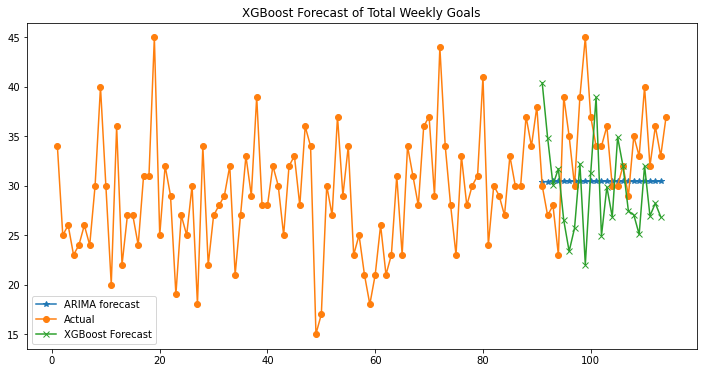

In [165]:
## Compare 
plt.figure(figsize=(12, 6))
plt.plot(forecast, label = 'ARIMA forecast', marker = '*')
plt.plot(pd.concat([y_train,y_test]), label="Actual", marker='o')
plt.plot(xgb_forecast, label="XGBoost Forecast", marker='x')
plt.title("XGBoost Forecast of Total Weekly Goals")
plt.legend()

Not strictly comparable - the time series had a training cut off at the end of the training data, while XGBoost made predictions based on test data variables (the lag variables in the test data)